# **Data Visualisation**

## Objectives

* Fulfil Business Requirement 1: 
Visually differentiate a healthy cherry leaf from one with powdery mildew.

* Answer hypothesis #2:
Average, variability and contrast plots can be improved by rotating and aligning leaves to same orientation before analysis

## Inputs

* inputs/datasets/raw/cherry-leaves/test 

## Outputs

* Thumbnail montage to display random selection of images from each label
* Average and Variability image plots for each label - healthy and mildew-infected
* Difference/contrast between labels image plot

## Additional Comments | Insights | Conclusions

* The thumbnail montage fulfilled business requirement 1 but average, variability and difference plots were less informative.
* The image rotation study was not completed as the code required was complex and this study was not required for fulfillment of business requirement 1.
* The malaria walkthrough project was used as a guide for the structure of this notebook and several functions were used 



---

# Setup

## Library Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shutil
import random
#import cv2 - required for image rotation study only
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image

2025-02-02 16:05:11.078727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 16:05:11.343608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set working directory

Change the working directory from its current folder to its parent folder

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector'

## Set input directories

set paths to specific data folders required in notebook

In [1]:
raw_data_dir = 'inputs/datasets/raw/cherry-leaves'
test_data_dir = 'inputs/datasets/raw/cherry-leaves/test'

print('the raw data directory is', raw_data_dir)
print('the test data directory is', test_data_dir)

the raw data directory is inputs/datasets/raw/cherry-leaves
the test data directory is inputs/datasets/raw/cherry-leaves/test


## Set output directory

In [14]:
version = 'v1' # change version number for each iteration
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('This version is already available - create a new version if required.')
    pass
else:
    os.makedirs(name=file_path)

This version is already available - create a new version if required.


## Set labels

In [8]:
labels = os.listdir(test_data_dir)
print('Labels for images are', labels)

Labels for images are ['healthy', 'powdery_mildew']


---

# Initial visual inspection

### Create a montage from a small selection of images for each label
* This provides an initial overview of image quality and content

Define function for generating montage

In [10]:
# This function was developed with assistance from ChatGPT
def generate_thumbnail_montage(data_dir, labels, new_size=(150, 150)):
    """
    Generates a single thumbnail montage with 2x2 grids for each label side-by-side.
    Args:
        data_dir (str): Path to the dataset directory.
        labels (list): List of labels (subfolders) to sample from.
        new_size (tuple): Desired size of each thumbnail image.

    Returns:
        None. Displays the montage in a Matplotlib plot.
    """
    if len(labels) != 2:
        raise ValueError("This function assumes exactly 2 labels for side-by-side layout.")

    # Create a figure for the montage
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows (for 2x2 grids), 4 columns (2x2 per label)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots

    for i, label in enumerate(labels):
        label_dir = os.path.join(data_dir, label)
        image_filenames = random.sample(os.listdir(label_dir), 4)  # Select 4 random images per label

        # Plot the 2x2 grid for the current label
        for j, img_file in enumerate(image_filenames):
            row = j // 2  # Determine row index (0 or 1)
            col = j % 2 + (i * 2)  # Determine column index; offset by 2 for the second label
            img_path = os.path.join(label_dir, img_file)
            img = image.load_img(img_path, target_size=new_size)
            img_array = image.img_to_array(img) / 255.0  # Normalize image

            # Display the image in the correct subplot
            axes[row, col].imshow(img_array)
            axes[row, col].axis('off')

        # Add a title spanning the 2x2 grid for the current label
        axes[0, i * 2].set_title(f"{label.capitalize()}", fontsize=16, loc='center')
        axes[0, i * 2 + 1].set_title("")  # Clear title for adjacent subplot

    plt.tight_layout()

    # Option to save the plot as a PNG file if required
    save_plot = input("Do you want to save this plot? (yes/no): ").strip().lower()

    if save_plot == "yes":
        output_path = os.path.join(file_path, "thumbnail_montage.png")
        plt.savefig(output_path, bbox_inches="tight", dpi=150)
        print(f"Montage saved to {output_path}")
    else:
        print("Montage not saved.")


    # Show the montage
    plt.show()



Call function to generate montage

Montage saved to outputs/v1/thumbnail_montage.png


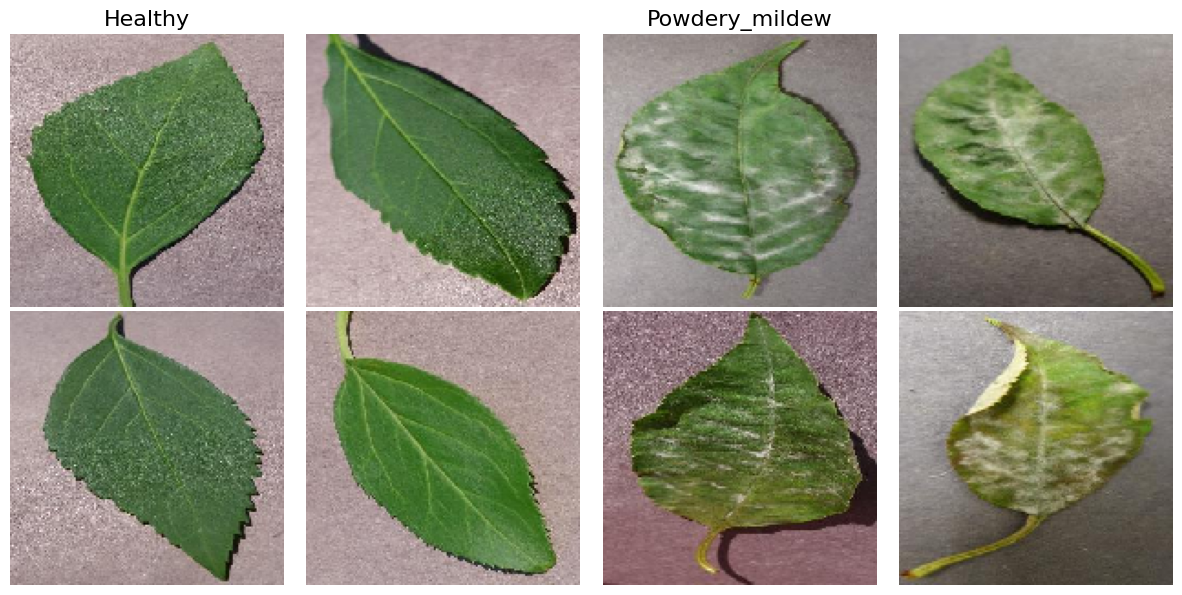

In [48]:

generate_thumbnail_montage(data_dir=test_data_dir, labels=labels, new_size=(150, 150))

---

# Image Average, Variability and Difference

## Average and variabilty of images per label

Define function to load images in array

In [10]:
# This code was refactored with assistance from ChatGPT
def load_images(my_data_dir, new_size=(50, 50), n_images_per_label=None):
    """
    Loads and preprocesses images from a directory into arrays.
    Parameters:
        my_data_dir (str): Path to the directory containing label subfolders.
        new_size (tuple): Tuple of (height, width) to resize images.
        n_images_per_label (int): Limit the number of images per label.
    Returns:
        X (numpy array): Array of image data with shape (n_samples, height, width, channels).
        y (numpy array): Array of corresponding labels.
    """
    X, y = [], []

    for label in labels:
        counter = 0
        for image_filename in os.listdir(f"{my_data_dir}/{label}"):
            if n_images_per_label is None or counter < n_images_per_label:
                # Load and resize the image
                img = image.load_img(f"{my_data_dir}/{label}/{image_filename}", target_size=new_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
                
                # Append image data and label
                X.append(img_array)
                y.append(label)
                counter += 1

    return np.array(X), np.array(y)

Define function to calculate average and vairability of image per label

In [11]:
# This code was refactored with assistance from ChatGPT
def calculate_mean_and_variability(X, y, file_path=file_path, figsize=(12, 5)):
    """
    Calculates and plots the average and variability for each label.
    Parameters:
        X (numpy array): Image data array of shape (n_samples, height, width, channels).
        y (numpy array): Array of corresponding labels.
        file_path : Path to save the output plots to correct version folder.
        figsize (tuple): Size of the plots.
    """
    unique_labels = np.unique(y)
    for label in unique_labels:
        # Filter images for the current label
        label_mask = y == label
        label_images = X[label_mask]

        # Calculate mean and variability
        avg_img = np.mean(label_images, axis=0)
        std_img = np.std(label_images, axis=0)

        print(f"==== Label {label} ====")
        print(f"Image Shape: {avg_img.shape}")
        
        # Plotting
        sns.set_style("white")
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].set_title(f"Average Image: {label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability Image: {label}")
        axes[1].imshow(std_img, cmap='gray')

        plt.tight_layout()

        # Option to save the plot as a PNG file if required
        save_plot = input("Do you want to save this plot? (yes/no): ").strip().lower()

        if save_plot == "yes":
            output_path = os.path.join(file_path, f"mean_var_montage_{label}_{version}.png")
            plt.savefig(output_path, bbox_inches="tight", dpi=150)
            print(f"Montage saved to {output_path}")
        else:
            print("Montage not saved.")

        plt.show()


Defiine path to dataset and image size

In [12]:
mean_var_path = test_data_dir
# Target image dimensions - could also use image size .pkl file
image_shape = (258, 258, 3)  

Load sample of images - vary sample size to adapt to accuracy requirements
* 50: not very accurate but fast computation speed
* 100-200: resonable accuracy but slower computation
* 500+: high accuracy but very slow computation

**NB:** image size will also impact accuracy and computation speeds

In [13]:
X, y = load_images(my_data_dir=mean_var_path, new_size=image_shape[:2], n_images_per_label=1000)

Calculate and plot average and variability

==== Label healthy ====
Image Shape: (258, 258, 3)
Montage not saved.


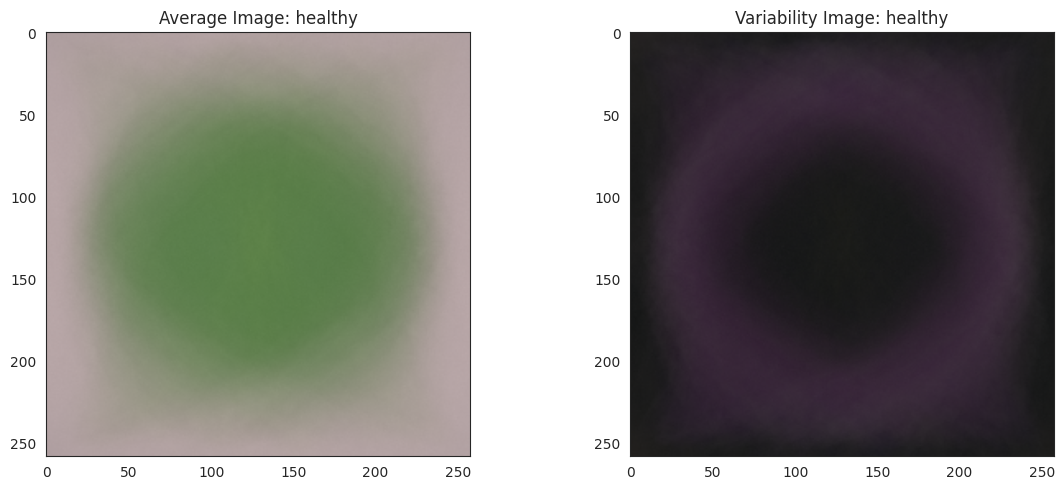

==== Label powdery_mildew ====
Image Shape: (258, 258, 3)
Montage not saved.


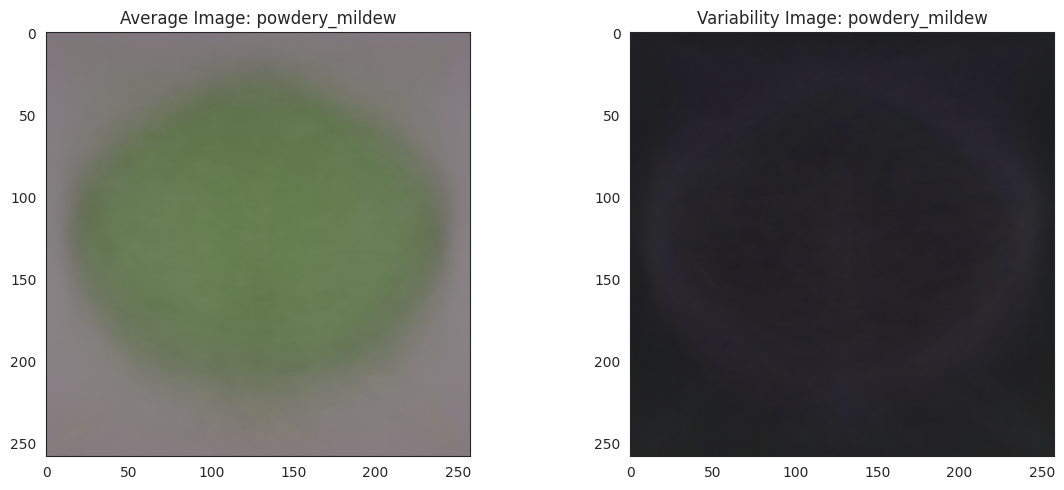

In [16]:
calculate_mean_and_variability(X, y, file_path=file_path)

### Conclusion | Initial Assessment
* Average and variability plots are not very informative, even when image size is full resolution and 500 images used per label.
* Accuracy is impacted because leaves have very defined shape and are not in same orientation in every image

### Next steps
* find a way to rotate images so leaves in same orientation before carrying out average and variability analysis

## Difference of mean image between labels
**functions were refactored with assistance from ChatGPT**

Define function that returns a subset of images for each label

In [14]:
def subset_images_by_label(X, y, label):
    """
    Filters images in X corresponding to a specific label in y.
    """
    if label not in np.unique(y):
        print(f"Label '{label}' not found in y. Available labels: {np.unique(y)}")
        return None
    # Create a boolean mask for the label
    mask = (y == label)
    return X[mask]

Define function that calculates image average for each label

In [15]:
def compute_average_image(X, y, label):
    """
    Computes the average image for a given label.
    """
    filtered_images = subset_images_by_label(X, y, label)
    if filtered_images is None or len(filtered_images) == 0:
        print(f"No images found for label '{label}'.")
        return None
    return np.mean(filtered_images, axis=0)

Define function that generates difference between labels plot

In [16]:
def plot_difference_between_labels(X, y, label_1, label_2, figsize=(20, 5)):
    """
    Plots the average images for two labels and their difference.
    Optionally saves the plot to a file.
    """
    # Compute average images
    avg_label_1 = compute_average_image(X, y, label_1)
    avg_label_2 = compute_average_image(X, y, label_2)
    
    if avg_label_1 is None or avg_label_2 is None:
        print("Unable to compute average images. Check the input labels.")
        return

    # Compute the difference image
    difference_image = avg_label_1 - avg_label_2

    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes[0].imshow(avg_label_1, cmap='gray')
    axes[0].set_title(f"Average: {label_1}")
    axes[1].imshow(avg_label_2, cmap='gray')
    axes[1].set_title(f"Average: {label_2}")
    axes[2].imshow(difference_image, cmap='gray')
    axes[2].set_title(f"Difference: {label_1} - {label_2}")

    for ax in axes:
        ax.axis("off")
    
    plt.tight_layout()

    # Option to save the plot as a PNG file if required
    save_plot = input("Do you want to save this plot? (yes/no): ").strip().lower()

    if save_plot == "yes":
        output_path = os.path.join(file_path, "diff_btwn_labels.png")
        plt.savefig(output_path, bbox_inches="tight", dpi=150)
        print(f"Difference plot saved to {output_path}")
    else:
        print("Difference plot not saved.")
    
    plt.show()

Calculate and plot difference between average image per label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Difference plot saved to outputs/v1/diff_btwn_labels.png


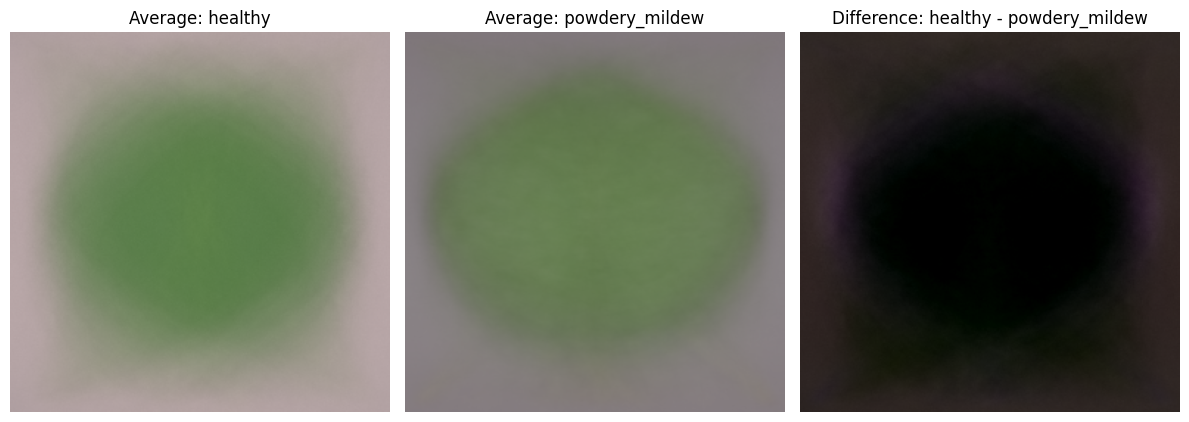

In [17]:
plot_difference_between_labels(
    X, y,
    label_1='healthy',
    label_2='powdery_mildew',
    figsize=(12, 5),
)

### Conclusion | Initial Assessment
* Difference plot is not very informative, even when image size is full resolution and 1000 images used per label.
* Accuracy is impacted because leaves have very defined shape and are not in same orientation in every image
* The most significant difference identified is the background and leaf borders.

### Next steps
* find a way to rotate images so leaves in same orientation before carrying out difference analysis

---

# Image Rotation

**Image rotation functions were developed with assistance from ChatGPT and Google AI studio (Gemini 2.0 Flash)**

### Goal:
* Identify leaf contour, tip and stem
* Rotate all leaf images in dataset to same axis

Define function to rotate image

In [8]:
def rotate_image(image, angle):
    """Rotate an image by a given angle."""
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, rotation_matrix, (cols, rows))

Define function to detect leaf tip and stem and rotate image accordingly

In [9]:
def correct_orientation_tip_stem(image):
    """
    Correct the orientation of a leaf image by detecting the tip and stem.
    Returns the rotated image, tip point, and stem point.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found.")
        return image, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    angle = rect[-1]

    # Adjust angle to be between -90 and 90
    if angle > 45:
        angle -= 90
    elif angle < -45:
        angle += 90

    rotated_image = rotate_image(image, -angle)
    rotation_matrix = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), -angle, 1)
    rotated_box = cv2.transform(np.array([box], dtype=np.float32), rotation_matrix).squeeze()

    # Estimate tip and stem
    y_coords = sorted([point[1] for point in rotated_box])
    stem_x_coords = [point[0] for point in rotated_box if point[1] == y_coords[0]]
    tip_x_coords = [point[0] for point in rotated_box if point[1] == y_coords[-1]]

    if stem_x_coords and tip_x_coords:
        stem_point = (int(np.mean(stem_x_coords)), int(y_coords[0]))
        tip_point = (int(np.mean(tip_x_coords)), int(y_coords[-1]))
    else:
        print("Failed to determine tip or stem points.")
        return rotated_image, None, None

    print(f"Tip point: {tip_point}, Stem point: {stem_point}")
    return rotated_image, tip_point, stem_point

Test functions on sample image

Tip point: (154, 295), Stem point: (137, -42)


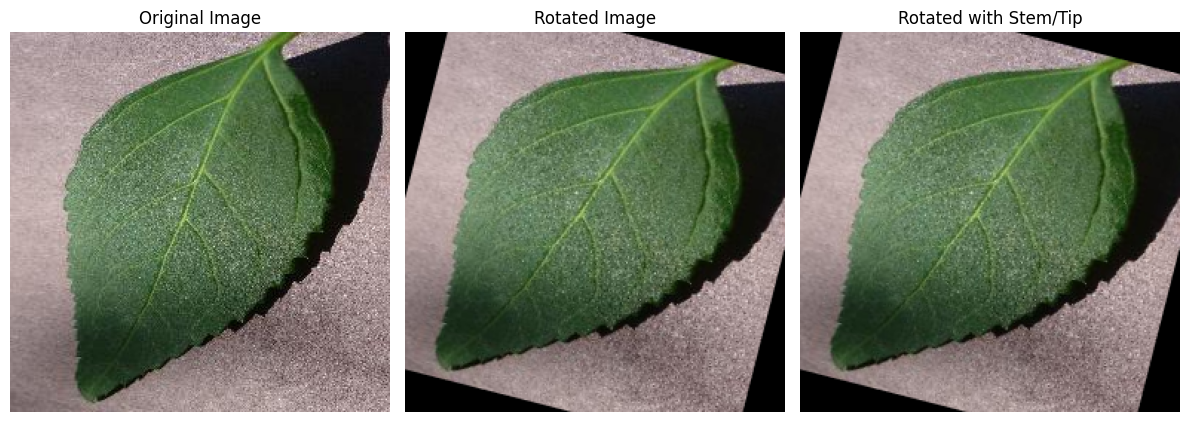

In [10]:
sample_image_path = "inputs/datasets/raw/cherry-leaves/test/healthy/eaf17e05-c2b7-4017-8553-1b11f0ba3941___JR_HL 4226_180deg.JPG"
sample_image = cv2.imread(sample_image_path)

if sample_image is not None:
    rotated_image, tip, stem = correct_orientation_tip_stem(sample_image)
    if tip and stem:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Rotated Image")
        plt.axis("off")

        rotated_image_display = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
        rotated_image_display = cv2.circle(rotated_image_display, tip, 5, (255, 0, 0), -1)  # Blue tip
        rotated_image_display = cv2.circle(rotated_image_display, stem, 5, (0, 0, 255), -1)  # Red stem

        plt.subplot(1, 3, 3)
        plt.imshow(rotated_image_display)
        plt.title("Rotated with Stem/Tip")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("Failed to detect tip or stem.")
else:
    print("Failed to load image.")

### Conclusion | Initial Assessment
* Image rotation functions are not yet reliable and require further development
* This function is not required for fulfillment of business requirement 1 and so development will be paused so that project can be progressed.

### Next steps
* Start model development for business requirement 2

---

# Client Image Montage Dataset

### Small dataset for use in client streamlit database for image montage generation

Define new directory path

In [9]:
montage_dir = "inputs/datasets/montage"

Define function to generate new directory 
- has ability to /refreshreplace content from test dataset if required

In [11]:
def create_montage_directory():
    if os.path.exists(montage_dir):
        shutil.rmtree(montage_dir)  # Clear previous contents
    os.makedirs(montage_dir, exist_ok=True)
    os.makedirs(os.path.join(montage_dir, "healthy"), exist_ok=True)
    os.makedirs(os.path.join(montage_dir, "powdery_mildew"), exist_ok=True)


Define function to populate new directory with randomly selected images from test dataset

In [12]:
def generate_montage_subset():
    create_montage_directory()  # Ensure a clean start

    for label in ["healthy", "powdery_mildew"]:
        class_dir = os.path.join(test_data_dir, label)
        montage_class_dir = os.path.join(montage_dir, label)

        # Get all image files in the class directory
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Select 50 random images (or all if fewer)
        selected_images = random.sample(image_files, min(50, len(image_files)))

        # Copy selected images to the new montage directory
        for image in selected_images:
            src_path = os.path.join(class_dir, image)
            dest_path = os.path.join(montage_class_dir, image)
            shutil.copy(src_path, dest_path)

    print("Montage dataset generated successfully!")


Generate montage dataset

In [13]:
generate_montage_subset()

Montage dataset generated successfully!


Generate montage from montage dataset

Montage not saved.


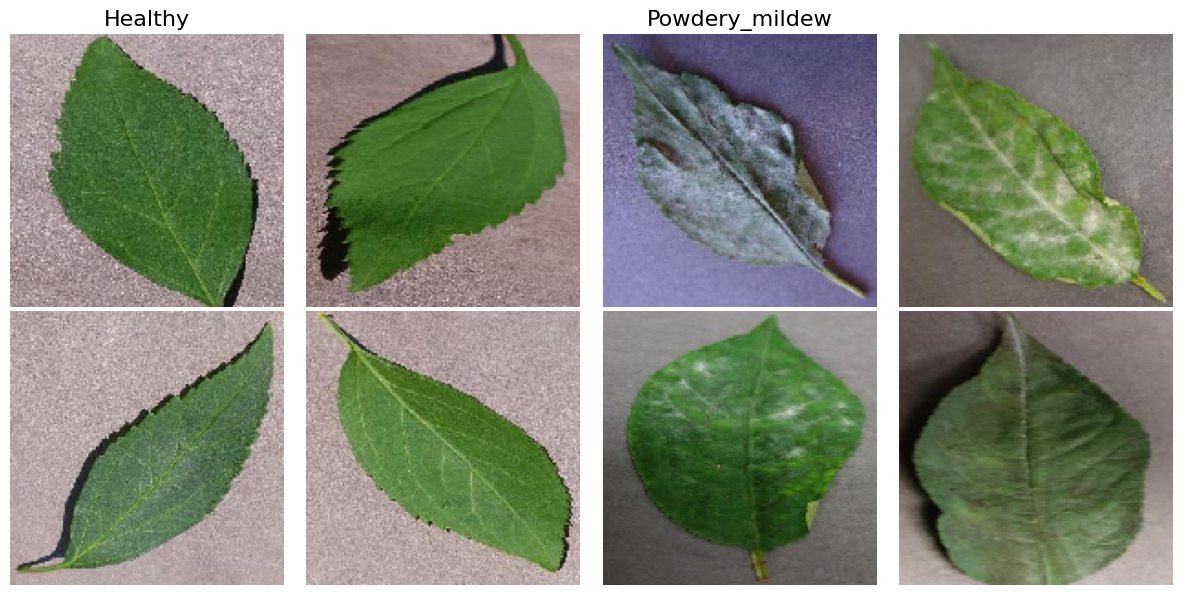

In [15]:
generate_thumbnail_montage(data_dir=montage_dir, labels=labels, new_size=(150, 150))

### Conclusion | Initial Assessment
* Have smaller dataset that is sample of test dataset for use in generating thumbnail image montage
* Can use dataset and montage grnarator function in streamlit dashboard

### Next steps
* add montage generator function to streamlit dashboard